In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Урок 8. GAN

## Домашнее задание

Обучите нейронную сеть любой архитектуры которой не было на курсе, либо обучите нейронную сеть разобранной архитектуры, но на том датасете, которого не было на уроках. Сделайте анализ, того, что вам помогло в улучшения работы нейронной сети.
* *вариант для 1) Обучите VAE на fashion_mnist
* *вариант для 1) Обучите GAN на одном классе CIFAR
* *вариант для 1) обучите классификатор на данных tfds (Kaggle, UCI)
* *вариант для 1) обучите семантическую сегментацию на tfds (Kaggle, UCI)
Сделайте краткий обзор какой-нибудь научной работы посвященной тому или иному алгоритму нейронных сетей, который не рассматривался на
курсе. Проведите анализ: Чем отличается выбранная вами на рассмотрение архитектура нейронной сети от других архитектур? В чем плюсы и минусы данной архитектуры? Какие могут возникнуть трудности при применении данной архитектуры на практике?

### Задание №1
Обучение GAN на одном классе CIFAR


### Подключение библиотек

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

import os
import matplotlib.pyplot as plt

import tensorflow.keras as keras
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

### Загрузка данных

In [3]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

class_num = 0
batch_size = 32
indices_train = np.where(y_train == class_num)
indices_test = np.where(y_test == class_num)

all_digits = np.concatenate([x_train, x_test])
all_digits = all_digits.astype("float32") / 255
indices_train = np.where(y_train == class_num)
indices_test = np.where(y_test == class_num)
all_digits = all_digits[indices_train,:,:]
all_digits = np.reshape(all_digits, (-1, 32, 32, 1))
dataset = tf.data.Dataset.from_tensor_slices(all_digits)
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size).prefetch(32)

print('all_digits shape:', all_digits.shape)

170508288/170498071 [==============================] - 2s 0us/step


2023-01-20 10:06:25.460088: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


all_digits shape: (30000, 32, 32, 1)


2023-01-20 10:06:25.461026: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-20 10:06:25.592821: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-20 10:06:25.593921: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-20 10:06:25.594770: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-20 10:06:25.595542: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

### Построение модели

In [4]:
discriminator = keras.Sequential(
    [
        keras.Input(shape=(32, 32, 1)),
        layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same'),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same'),
        layers.LeakyReLU(alpha=0.2),
        layers.GlobalMaxPooling2D(),
        layers.Dense(1),
    ],
    name="discriminator",
)

discriminator.summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 64)        640       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 128)         73856     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
global_max_pooling2d (Global (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 74,625
Trainable params: 74,625
Non-trainable params: 0
_________________________________________________

In [5]:
latent_dim = 64

generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        layers.Dense(32 * 32 * 64),
        layers.LeakyReLU(alpha=0.2),
        layers.Reshape((32, 32, 64)),
        layers.Conv2DTranspose(64, (3, 3), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(256, (3, 3), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(1, (32, 32), padding="same", activation="sigmoid"),
    ],
    name="generator",
)

generator.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 65536)             4259840   
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 65536)             0         
_________________________________________________________________
reshape (Reshape)            (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 32, 32, 64)        36928     
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 32, 32, 256)       147712    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 32, 32, 256)       0 

In [6]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    def train_step(self, real_images):
        if isinstance(real_images, tuple):
            real_images = real_images[0]
        # берем случайный пример из скрытого пространства
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # строим по нему фейковое изображение
        generated_images = self.generator(random_latent_vectors)

        # собрали с реальным изображением в тензор
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # задаем метки 1 и 0 соответственно
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        # добавляем шум
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # обучаем discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        #выбрали случайный пример в скрытом пространстве
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # собрали метки реальных изображений
        misleading_labels = tf.zeros((batch_size, 1))

        # обучаем generator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))
        return {"d_loss": d_loss, "g_loss": g_loss}

In [7]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=64):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = keras.preprocessing.image.array_to_img(generated_images[i])
            img.save("generated_img_{i}_{epoch}.png".format(i=i, epoch=epoch))


### Обучение модели

In [8]:
epochs = 25

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.SGD(),
    g_optimizer=keras.optimizers.SGD(),
    loss_fn=keras.losses.BinaryCrossentropy(from_logits=True),
)

gan.fit(
    dataset, epochs=epochs, callbacks=[GANMonitor(num_img=3, latent_dim=latent_dim)]
)

Epoch 1/25


2023-01-20 10:06:31.111979: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2023-01-20 10:06:34.038690: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


938/938 [==============================] - 43s 31ms/step - d_loss: 0.5610 - g_loss: 0.8675
Epoch 2/25
938/938 [==============================] - 27s 29ms/step - d_loss: 0.2392 - g_loss: 2.0892
Epoch 3/25
938/938 [==============================] - 27s 29ms/step - d_loss: 0.2890 - g_loss: 2.1803
Epoch 4/25
938/938 [==============================] - 28s 30ms/step - d_loss: 0.1154 - g_loss: 3.9775
Epoch 5/25
938/938 [==============================] - 28s 29ms/step - d_loss: 0.2693 - g_loss: 2.1320
Epoch 6/25
938/938 [==============================] - 28s 30ms/step - d_loss: 0.5628 - g_loss: 1.1577
Epoch 7/25
938/938 [==============================] - 28s 30ms/step - d_loss: 0.6253 - g_loss: 0.9122
Epoch 8/25
938/938 [==============================] - 28s 30ms/step - d_loss: 0.6089 - g_loss: 0.9361
Epoch 9/25
938/938 [==============================] - 28s 30ms/step - d_loss: 0.6345 - g_loss: 0.8832
Epoch 10/25
938/938 [==============================] - 28s 30ms/step - d_loss: 0.6236 - g_los

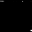

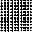

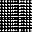

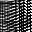

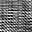

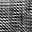

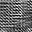

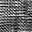

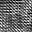

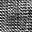

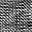

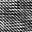

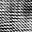

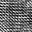

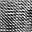

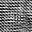

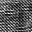

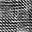

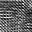

In [9]:
from IPython.display import Image, display

for i in range(1,20):
  display(Image("generated_img_0_"+str(i)+".png"))

### Вывод
В улучшении работы сети помогли следующие параметры: latent_dim равный 64, 25 эпох, оптимизатор SGD

### Задание 2
Modeling Long- and Short-Term Temporal Patterns with Deep Neural Networks

https://arxiv.org/pdf/1703.07015.pdf

Рекурентная модель с пропуском слоя, которая настроена так, чтобы учитывать переодичность данных. Оказалось, что во многих временных рядах есть ситуации, которые плохо моделируются нелинейными моделями глубокого обучения. В статье приводится описание адаптации архитектуры с помощью традиционной линейной модели - авторегрессии (AR). Итоговая модель LSTNet, комбинировала выходы модели AR и модели с обычным рекурентным слоем и параллельным пропуском рекурентного слоя.

Выходные данные сверточного слоя передаются recurent-skip компоненту. Закрытый рекуррентный нейрон разворачивается через q временных шагов. Выходы от развернутых нейронов, разделенных заранее заданным временным интервалом (сезонным периодом), позже используются в сети. На практике рекурентные нейроны не фиксируют долгосрочные зависимости. При прогнозировании потребления электроэнергии измерения за предыдущий день могут быть очень полезными предикторами. Введя пропуск подключений с интервалом в 24 часа, авторы гарантируют, что модель может использовать эти исторические зависимости.